#**D604 Advanced Analytics**  
## Performance Assessment #2 – Sentiment Analysis

Bernard Connelly  
Master of Science, Data Analytics, Western Governors University  
Dr. Sherin Aly  

---

# Part 1: Research Question  

### A1. Research Question  
Can a neural network model using Natural Language Processing techniques accurately classify online reviews as positive or negative?

### A2. Objectives of Analysis  
The objective of this analysis is to build a neural network capable of classifying Amazon product reviews as positive or negative. This will begin with cleaning and preprocessing the data by removing unusual characters, tokenizing, padding, and normalizing the text. I will then develop a model architecture that includes embedding, recurrent, and dense layers, with an LSTM network at its core to handle sequential language data. The model will be trained and validated using appropriate performance metrics, and final recommendations will be made based on its predictive accuracy and business value.

### A3. Neural Network Selection  
A Recurrent Neural Network will be used to train this data - specifically a Long Short-Term Memory (LSTM) network will be implemented. A LSTM is industry-relevant as they are designed to capture sequential data, making them ideal for NLP. This network type is an excellent starting point for this type of analysis and has yielded relevant results in this category in many similar scenarios.

# Part 2: Importing & Preprocessing  


In [1]:
# Packages and Libraries
import pandas as pd # Calculations
import numpy as np # Dataframes
import re # Regular Expressions
import string # To access and remove punctuation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization
import warnings # Squelch warnings
warnings.filterwarnings("ignore") # Squelch warnings
from sklearn.model_selection import train_test_split # Train/Test Split
from google.colab import files # Downloading files

import tensorflow as tf # Neural Network
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Padding
from tensorflow.keras.models import Sequential # Sequential Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout # Layers
from tensorflow.keras.callbacks import EarlyStopping # Early Stopping
from tensorflow.keras.models import load_model # Loading Model
import json # Saving Model History

In [2]:
# Importing Dataset & Initial Profiling
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/amazon_cells_labelled.txt', sep='\t', header=None, names=['sentence','label'])
print("Dataset Header:\n", df.head())
print("\nShape:")
print(df.shape)
print("\nData Types:\n", "Sentence Data Type:", df['sentence'].dtype)
print(" Labels Data Type:", df['label'].dtype)

Dataset Header:
                                             sentence  label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1

Shape:
(1000, 2)

Data Types:
 Sentence Data Type: object
 Labels Data Type: int64


### B1. Exploratory Data Analysis of unusual characters, vocabulary size, word embedding length and maximum sequence length  

**B1a. Identifying Unusual Characters**

In [3]:
## Identifying Unusual Characters
unusual_chars = set()
for s in df['sentence']:
    for c in s:
        if ord(c) > 127:
            unusual_chars.add(c)

print("Unusual Characters:", unusual_chars)


Unusual Characters: set()


No unusual characters were found in the dataset. However, there were instances of emoticons in the dataset, so I created an additional loop to search for various versions of those.

In [4]:
# Finding Emoticons
emoticon_patterns = r'[:;=8][\-o\*\']?[\)\(D]'
emoticon_matches = []

for s in df['sentence']:
    found = re.findall(emoticon_patterns, s)
    if found:
        emoticon_matches.extend(found)

print("Emoticons found:", set(emoticon_matches))


Emoticons found: {':-)', ':)'}


The project did not explicitly call out actioning emoticons, only emojis, but it was worthwhile to identify those that were present. Before tokenizing the data, I will perform standard cleaning to remove the emoticons and make all text lowercase, removing extra spaces and punctuation to ensure the cleanest tokenization possible. I opted to maintain stopwords since sentiment analysis can find value in stopwords to "comprehend the subtleties and emotional tone of the text" (Singh, 2023).



In [5]:
# Performing standard cleaning steps

def clean_text(text):
  text = text.lower() ## Making values lowercase
  text = re.sub(r'[:;=8][\-o\*\']?[\)\(dDpP]', '', text) ## Removing emoticons
  text = re.sub(r'\s+', ' ', text) ## Removing extra spaces
  text = text.translate(str.maketrans('', '', string.punctuation)) ## Removing punctuation
  return text

df['sentence'] = df['sentence'].apply(clean_text)

In [6]:
# Confirming cleaning worked properly

## Finding Emoticons
emoticon_patterns = r'[:;=8][\-o\*\']?[\)\(D]'
emoticon_matches = []

for s in df['sentence']:
    found = re.findall(emoticon_patterns, s)
    if found:
        emoticon_matches.extend(found)

print("Emoticons found:", set(emoticon_matches))
print("\nHeader:")
print(df.head())

Emoticons found: set()

Header:
                                            sentence  label
0  so there is no way for me to plug it in here i...      0
1                          good case excellent value      1
2                              great for the jawbone      1
3  tied to charger for conversations lasting more...      0
4                                   the mic is great      1


**B1b. Vocabulary Size**

In [7]:
# Tokenize dataset & identify unique word count

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['sentence'])
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df['sentence'])

print ("Unique Words Count:", len(tokenizer.word_index))
## Confirming results
print("\nExample sentence:", df['sentence'][0])
print("Tokenized:", sequences[0])


Unique Words Count: 1906

Example sentence: so there is no way for me to plug it in here in the us unless i go by a converter
Tokenized: [34, 117, 6, 59, 211, 12, 51, 9, 154, 5, 20, 331, 20, 2, 540, 541, 3, 237, 186, 7, 792]


After tokenizing the set, a total of 1906 unique words were identified. This value is well under standard thresholds typically used in an LSTM (10,000 words). The full vocabulary was retained without limiting or capping the number of words so that the model can learn from all available text without significant processing power costs.

**B1c. Word Embedding Length**  
The model will use an embedding layer to convert each token into a dense vector. The industry standard embedding length for an LSTM model is 128 dimensions, so this will be the starting point for my model. If the results indicate the model is overfitting too quickly, or the dataset size to embedding size ratio does not produce accurate results, this value may be edited before the final run of the model.

**B1d. Justification for Sequence Length**

90% of all sentences are captured with a sequence length of 20. Additionally, the maximum review length was 30 words. The value 20 will be selected as the maximum length to retain nearly all reviews in the dataset while minimizing the amount of padding required for shorter reviews. This is a healthy median  amount to preserve the majority of the sentences in the dataset while reducing overall computational costs.



In [8]:
# Identifying Sequence Length + Descriptive Statistics
sentence_lengths = [len(seq) for seq in sequences]

print("Mean length:", np.mean(sentence_lengths))
print("Median length:", np.median(sentence_lengths))
print("Max length:", np.max(sentence_lengths))
print("90th percentile:", np.percentile(sentence_lengths, 90))
print("95th percentile:", np.percentile(sentence_lengths, 95))

Mean length: 10.196
Median length: 9.0
Max length: 30
90th percentile: 20.0
95th percentile: 23.0


In [9]:
# Setting maximum length and padding the smaller sequences
max_length = 20
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

## Validating changes
padded_shape = np.array(padded_sequences).shape
print("Shape of padded sequences:", padded_shape)
print("\nExample sentence:", df['sentence'][1])
print("Padded:", padded_sequences[1])

Shape of padded sequences: (1000, 20)

Example sentence: good case excellent value
Padded: [ 22  49  54 265   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


### B2. Describe the Tokenization Process  
The goal of the tokenization process is to convert the raw text into a numerical format that an ML model can understand. For this project, the process included normalizing the text, breaking each sentence into individual words, assigning a unique ID to each word, and converting all sentences into sequences of those IDs. An out-of-vocabulary variable is also created to cover any texts that may have been cut from the dataset - this is just best practices, as there was no limit placed on the vocabulary for this project. Finally, the sequences were padded with additional zeroes to ensure they could be passed into the LSTM model for classification.

For normalization, the steps taken were to convert all text to lowercase, remove all punctuation and emoticons, and remove extra spaces. This was accomplished using the following code:

```
import re # Regular Expressions
import string # To access and remove punctuation

def clean_text(text):
  text = text.lower() ## Making values lowercase
  text = re.sub(r'[:;=8][\-o\*\']?[\)\(dDpP]', '', text) ## Removing emoticons
  text = re.sub(r'\s+', ' ', text) ## Removing extra spaces
  text = text.translate(str.maketrans('', '', string.punctuation)) ## Removing punctuation
  return text

df['sentence'] = df['sentence'].apply(clean_text)
```

Tokenization was performed using the Tokenizer class, and was accomplished with the following code:

```
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['sentence'])
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df['sentence'])

print ("Unique Words Count:", len(tokenizer.word_index))
```

Of note, the `fit_on_texts()` & `texts_to_sequences()` methods are also both from the Tokenizer class.

### B3. Explanation of Padding Process  
To prepare the tokenized sequences for input into an LSTM model, each sequence must be the same length. Since the review sentences in the Amazon dataset vary in length, shorter sequences were padded with zeroes, and longer sequences were truncated to creat inputs with a uniform shape. This is a necessary step for deep learning models, which require input to be in a consistent 2D matrix format - otherwise the model cannot process data correctly.

To determine a reasonable cutoff point for sequence length, I calculated the metrics for sentence lengths, identified where the 90th percentile was, and utilized that value for a reasonable maximum length cutoff (20 tokens).

I used the `pad_sequences()` function from `tensorflow.keras.preprocessing.sequence` to perform the padding on this dataset. The padding was applied to the end of each sequence (`padding='post')`. Truncating was also performed on the end of each sentence (`truncating='post')` as typically the most relevant information and context in a review occurs at the beginning of the sentence.

```
from tensorflow.keras.preprocessing.sequence import pad_sequences # Padding

print("\nExample sentence:", df['sentence'][1])
print("Padded:", padded_sequences[1])

Example sentence: good case excellent value
Padded: [ 22  49  54 265   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
```

### B4. Sentiment Categories & Dense Activation Function  

This project uses binary classification to predict the sentiment of each Amazon review. Positive sentiments will be labeled as 1, and negative sentiments will be labeled as 0. As such, the model is predicting two possible outcomes.

A sigmoid activation function will be used for the final dense output layer. This function outputs a value between 0 and 1, representing the positive review's probability. It is ideal for binary classification problems as it allows a simple decision-making rule - any values greater than or equal to .5 are labeled as positive.

### B5. Preparation Steps and Data Split  
An industry-standard Train/Validation/Test split of 80/10/10 was used for this project, which aligns with best practices for machine learning models. 80% will be used to train the model and update the parameters and weights. 10% will be used to validate and tune hyperparameters and monitor for overfitting with best practices for machine learning models. 80% will be used to train the model and update the parameters and weights. 10% will be used to validate and tune hyperparameters and monitor for over or underfitting. Finally, 10% will be used to evaluate the model's effectiveness and generalization to unseen data.

The `train_test_split()` function from Scikit-learn is used to perform this analysis, and they were stratefied based upon the class labels to preserve the balance between positive and negative reviews in the set.

In [10]:
# Splitting the Dataset for Training, Validation and Testing

X = np.array(padded_sequences)
y = np.array (df['label'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### B6. Create Copy of the Prepared Dataset   

In [11]:
'''
# Compiling and saving the prepared dataset
save_path = ('/content/drive/MyDrive/Colab_Notebooks/prepared_dataset.csv')
labels = np.array(df['label'])
prepared_df = pd.DataFrame(padded_sequences)
prepared_df['label]'] = labels
prepared_df['cleaned_text'] = df['sentence']
prepared_df.to_csv(save_path, index=False)
'''

"\n# Compiling and saving the prepared dataset\nsave_path = ('/content/drive/MyDrive/Colab_Notebooks/prepared_dataset.csv')\nlabels = np.array(df['label'])\nprepared_df = pd.DataFrame(padded_sequences)\nprepared_df['label]'] = labels\nprepared_df['cleaned_text'] = df['sentence']\nprepared_df.to_csv(save_path, index=False)\n"

# Part 3: Network Architecture  

### C1. Model Summary

In [12]:
# Define & Build RNN + LSTM Model
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size,
              output_dim=100,
              input_length=max_length),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [13]:
# Compiling Model & Outputting Summary
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

# Defining Early Stopping
early_stop = EarlyStopping(
monitor='val_loss',
patience=3,
restore_best_weights=True
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20, 100)        │       190,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,053 (918.18 KB)

 Trainable params: 235,053 (918.18 KB)

 Non-trainable params: 0 (0.00 B)

### C2. Discussion of Layers, Types, and Parameters

The model contains five distinct layers: one Embedding, one LSTM, one Dropout, and two Dense layers.  Each layer has a distinct purpose to transform and learn from the dataset. The initial Embedding layer allows the model to learn meaningful vector representations of words. The LSTM layer is used to capture word order and context which is uniquely helpful in understanding sentiment. The Dropout layer ensures the model does not become overly dependent on a single node by randomly turning off neurons during training.

The first Dense layer has 32 units and uses a RelU activation function. This layer processes the output from the LSTM learns how to combine the weights and other features, enabling the model to detect less obvious sentiment patterns. The final dense layer contains a single neuron and uses a sigmoid function to condense the learned information into a probability value between 0 and 1. The output of this final layer represents the model's confidence that the review expresses positive sentiment.

The model contains 235,053 trainable parameters, all of which are optimized to improve the model's ability to successfuly clasify sentiment.

### C3. Hyperparameter Choice and Justification  

**Activation Functions**  
The model uses two activation functions throughout its layers - RelU for the Dense 32 unit layer, and Sigmoid for the final Dense Output layer. The RelU function in the Dense hidden layer facilitates efficient training, enables complex feature learning, and avoids vanishing gradients extracted by the LSTM layer. This is a standard choice for hidden layers in deep learning models. The Sigmoid function is optimal for condensing the learned information in a single neuron layer down to a probability between 0 and 1 for predicting the correct sentiment and is a standard baseline activation function for this model type.

**Number of Nodes per Layer**  
The initial embedding layer was set to output vectors of length 100. This controls how richly each word is represented - and since the dataset is relatively small (1000 sentences with 1901 unique tokens), a standard default like  128 could run the risk of overfitting. If underfitting is observed, this value may be increased in future tuning.  

The LSTM layer has 64 units, a common starting point that provides sufficient learning capacity. A smaller size could miss important details, and a larger size could introduce unnecessary complexity. The dropout layer has no units, but randomly disables 50% of the LSTM output neurons during training to avoid overfitting and dependence on any single node.   

The Dense layer with 32 units follows, using a ReLU activation to help the model learn higher-level feature combinations extracted from the LSTM layer. The Final Dense output layer consists of 1 unit with a Sigmoid activation, which is used to output a probability score between 0 and 1 indicating the likelihood of positive sentiment.

**Loss Function**  
The model uses `binary crossentropy` as the loss function. This is the standard loss function for binary classification problems where the target label is 0 or 1. `Binary crossentropy` measures the difference between the predicted probability and the actual label, more heavily penalizing confident but incorrect predictions. It is especially well-suited when using a Sigmoid activation in the output layer, as both deal with outputs representing probabilities, and the model is pushed towards improving the probability outputs in a consistent way.

**Optimizer**  
`Adam` (Adaptive Moment Estimation) was used for this network. Amongst its strengths, `Adam` combines two optimization techniques - momentum and RMSProp (Root Mean Squared Propagation). In more lay terms, this means it remembers the general direction the gradients are going, smooths out gradient descent (momentum), and scales the learning rate for each weight by maintaining a running average of squared gradients (RMSProp). Each step determines how the loss changed and which weights were responsible, and adjusts them based on past updates and the reliability of the gradient. Regarding the learning rate, 0.001 is the standard learning rate for `Adam`. Broadly speaking, it is a safe, stable default for `Adam` across various problems and architectures. Additionally, since `Adam` adapts the learning rate for each weight internally, there is no need for a very large or small learning rate.

**Stopping Criteria**  
The training process uses an early stopping callback to prevent overfitting. This monitors the validation loss during training, and if the loss does not improve for a set number of consecutive epochs (3), training is halted. This ensures the model stops learning when further training would not improve performance and may begin to overfit.

# Part 4: Neural Network Model Evaluation  


In [14]:

# Training the Model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.4729 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5273 - loss: 0.6934 - val_accuracy: 0.4300 - val_loss: 0.6936
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5795 - loss: 0.6901 - val_accuracy: 0.6500 - val_loss: 0.6830
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7226 - loss: 0.5639 - val_accuracy: 0.7400 - val_loss: 0.6495
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9458 - loss: 0.1726 - val_accuracy: 0.8000 - val_loss: 0.5721
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9879 - loss: 0.0425 - val_accuracy: 0.8500 - val_loss: 0.5809
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9949 - loss: 0.0362 - val_accuracy: 0.8000 - val_loss: 0.8585
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9973 - loss: 0.0151 - val_accuracy: 0.7900 - v

### Saving & Loading Model Results
*The below code was implemented to avoid having to re-run the entire model & identify new results every time the runtime was disconnected. This ensures continuity in analysis and avoids random initialization and data shuffling every time the model is run.*

*For ease of use, the coding below this cell uses the history artifacts for analysis. These should remain valid as they will be saved based on the final run of the model.*

**In other words, the training model was re-run above to demonstrate the functionality of the code, however, the metrics in the  may not match the analysis below exactly (within a few hundreths), but should be close enough to simulate the values for the initial run through saved in the history.**

In [15]:
'''
# Saving the trained model
model.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Sentiment_Model.keras')

# Saving the training history
with open('/content/drive/MyDrive/Colab_Notebooks/Sentiment_Model_training_history.json', 'w') as f:
    json.dump(history.history, f)
'''

"\n# Saving the trained model\nmodel.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Sentiment_Model.keras')\n\n# Saving the training history\nwith open('/content/drive/MyDrive/Colab_Notebooks/Sentiment_Model_training_history.json', 'w') as f:\n    json.dump(history.history, f)\n"

In [16]:
# Loading the Model & History
model = load_model('/content/drive/MyDrive/Colab_Notebooks/Trained_Sentiment_Model.keras')
with open('/content/drive/MyDrive/Colab_Notebooks/Sentiment_Model_training_history.json', 'r') as f:
    history = json.load(f)


### D1. Impact of Stopping Criteria  
The stopping criteria were critical to ensure the model did not overfit to the training data. After eight epochs of training, the model was paused as it had achieved extremely high accuracy with minimal loss, and further training showed virtually no improvement. The code below pulls the data from the final training epoch, demonstrating the model's performance at the point of stopping.


In [17]:
# Pull final epoch results
final_epoch = len(history['loss']) - 1
print(f"Final Epoch: {final_epoch + 1}")
print(f"Training Loss: {history['loss'][final_epoch]:.4f}")
print(f"Validation Loss: {history['val_loss'][final_epoch]:.4f}")
print(f"Training Accuracy: {history['accuracy'][final_epoch]:.4f}")
print(f"Validation Accuracy: {history['val_accuracy'][final_epoch]:.4f}")

Final Epoch: 8
Training Loss: 0.0129
Validation Loss: 0.7310
Training Accuracy: 0.9975
Validation Accuracy: 0.8300


### D2. Assess Fitness of Model and Over/Underfitting  
The model demonstrated strong fitness during training, achieving a training accuracy of 99.75% and a validation accuracy of 83% by the final epoch. While training loss remained extremely low, the validation loss was notably higher, suggesting the presence of some overfitting. However, early stopping was implemented and triggered after eight epochs, which helped prevent the model from overfitting more severely.

Several design choices were made to mitigate the risk of overfitting:
* A Dropout layer was included after the LSTM layer, randomly disabling 50% of  neurons during training to reduce reliance on specific neurons and improve generalization.
* Early stopping was used to monitor validation loss and halt training once performance stopped improving.
* The Embedding layer’s output dimension was reduced to 100 rather than a typical 128 to lower model complexity relative to the small dataset size.

Although some overfitting was observed, these mitigation strategies allowed the model to maintain a reasonably strong validation performance without extensive overtraining.


### D3. Charting the Model's Training Process

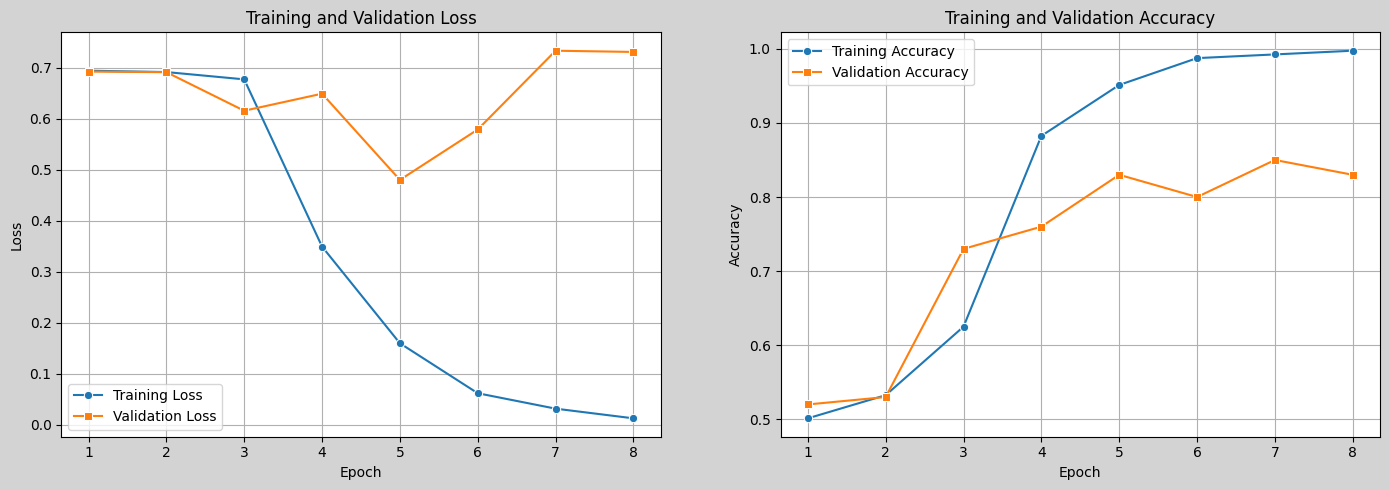

In [18]:
# Plotting Accuracy & Loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.patch.set_facecolor('lightgray')

# Loss Chart
sns.lineplot(x=range(1, len(history['loss']) + 1), y=history['loss'], label='Training Loss', ax=ax1, marker='o')
sns.lineplot(x=range(1, len(history['val_loss']) + 1), y=history['val_loss'], label='Validation Loss', ax=ax1, marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.grid(True)
ax1.legend()

# Accuracy Chart
sns.lineplot(x=range(1, len(history['accuracy']) + 1), y=history['accuracy'], label='Training Accuracy', ax=ax2, marker='o')
sns.lineplot(x=range(1, len(history['val_accuracy']) + 1), y=history['val_accuracy'], label='Validation Accuracy', ax=ax2, marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

### D4. Predictive Accuracy of the Model

In [19]:
# Evaluating the model on the unseent test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8150 - loss: 0.5323 
Test Loss: 0.5509
Test Accuracy: 0.7900


After using the trained model on the unseen data in the test dataset, the model achieved an accuracy of 79% and a test loss of 0.55. These results indicate the model generalized reasonably well beyond the training and validation datasets.  

While there was a slight decrease in performance compared to the validation dataset (83% validation accuracy vs 79% test accuracy), this level of variance is expected and reflects natural differences between training data and new, unseen examples. The model correctly classified most reviews, demonstrating strong predictive capabilities relative to the dataset's size and complexity.  

The model provides effective sentiment classification with a balanced trade-off between model complexity and predictive accuracy.

### D5. Compliance with AI Global Ethics Standards & Bias Mitigation  
In accordance with the OECD AI values-based principles (OECD, 2019), this analysis was conducted with a focus on fairness, transparency, and bias mitigation to comply with global ethical standards for AI. The dataset used for training contained a balanced representation of positive and negative reviews, reducing the risk of class imbalance bias. All data cleaning and preprocessing steps were documented, and care was taken to preserve the original sentiment of the reviews, minimizing opportunities for introducing unintended biases.

The data cleaning process avoided aggressive removal of words that could alter sentiment, and standard practices were applied throughout, including the use of the Adam optimizer and binary cross-entropy loss function. Additionally, the model's architecture followed a well-established pattern for LSTM networks, consistent with industry norms and minimizing the likelihood of introducing hidden biases through model design.

Finally, potential biases favoring specific language patterns were mitigated by retaining stopwords and preserving full sentence structure, allowing the model to learn from natural language usage without distortion.

# Part 5: Summary and Recommendation  

### E. Provide the code used to save the trained model
model.save('/content/drive/MyDrive/Colab_Notebooks/Trained_Sentiment_Model.keras')

### F. Functionality of the model & Impact of Network Architecture Choice  

After training, the developed LSTM model achieved a test accuracy of 79% on unseen data, demonstrating a strong level of predictive capability for a first-pass sentiment analysis model. The network architecture was carefully designed to balance model complexity and generalization ability. By incorporating dropout regularization and early stopping, the model effectively minimized overfitting, preserving its ability to generalize to new examples.

Using a binary cross entropy loss function combined with a sigmoid activation function in the output layer ensured the model produced well-calibrated probability outputs between 0 and 1, essential for binary classification tasks. Additionally, selecting an LSTM architecture allowed the model to capture critical sequential dependencies in the review text, further enhancing prediction accuracy.

The model architecture supported efficient and practical learning, achieving strong performance while utilizing several industry-standard approaches.

### G. Recommended Course of Action & Results  
Based on the model’s test accuracy of approximately 79%, the LSTM network was able to correctly predict the sentiment of reviews in roughly four out of five cases. This represents a positive outcome for a first iteration model and demonstrates the potential for substantial time and cost savings if deployed at scale compared to a manual review process. For example, Amazon could employ this model to automate the categorization of product reviews, significantly reducing the effort involved in human sentiment assessment.

Despite its success, several enhancements could further improve the model’s performance before full deployment. First, the early stopping criteria could be adjusted to trigger sooner — by reducing the patience level — to better prevent overfitting. The loss and accuracy curves demonstrate that training and validation loss began to diverge around the fourth epoch, but training continued until the eighth epoch. Stopping training earlier may have reduced overfitting risk and slightly improved generalization performance.

Additionally, the model’s architecture could be fine-tuned. The embedding dimension could be adjusted upward to 128 or downward to 64 to better align with standard powers of two, which may improve the model’s ability to learn richer feature representations. Further hyperparameter tuning, such as adjusting LSTM unit size, dropout rate, or batch size, could also contribute to improving predictive accuracy and reducing overall loss.

Overall, the current model provides a strong foundation, and with targeted refinements, its performance could be further optimized for real-world deployment.

# Part 6: Sources

### Acknowledgement of Code Sources

Some logic and analysis were taken from the project created for D604 Task 1 - Neural Networks

### Acknowledgement of Sources

Singh, M. G. (2023, August 29). To use or lose stop words in NLP. Medium. https://medium.com/@gelsonm/to-use-or-lose-stop-words-in-nlp-de946edaa468

OECD. (2019). AI principles. OECD. https://www.oecd.org/en/topics/sub-issues/ai-principles.html

